<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Object_Detection/YOLOv3(2018).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 참고 코드
- https://github.com/ayooshkathuria/YOLO_v3_tutorial_from_scratch
- https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLOv3
- https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook
- https://github.com/pjreddie/darknet
- https://github.com/eriklindernoren/PyTorch-YOLOv3

# 1. Kaggle에서 VOC Dataset 다운로드

In [1]:
# download kaggle API
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)


In [2]:
cd /root

/root


In [3]:
# make .kaggle directory
# kaggle APL을 사용하려면, /root/.kaggle/ 에 kaggle.json을 업로드 해야합니다.
!mkdir .kaggle

In [4]:
cd /root/.kaggle/

/root/.kaggle


In [5]:
# kaggle 홈페이지에서 로그인 한뒤에 account 탭에 들어가서 kaggle.json을 다운로드 합니다.
# 다운로드한 kaggle.json을 /root/.kaggle/ 에 업로드 합니다.
from google.colab import files
file_uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
cd ..

/root


In [7]:
cd ..

/


In [8]:
# download pre-processed voc dataset
!kaggle datasets download -d aladdinpersson/pascal-voc-dataset-used-in-yolov3-video

 99% 4.28G/4.31G [01:27<00:01, 26.0MB/s]
100% 4.31G/4.31G [01:28<00:00, 52.5MB/s]


In [9]:
# unzip
!unzip -n pascal-voc-dataset-used-in-yolov3-video.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: PASCAL_VOC/labels/2009_004289.txt  
  inflating: PASCAL_VOC/labels/2009_004290.txt  
  inflating: PASCAL_VOC/labels/2009_004291.txt  
  inflating: PASCAL_VOC/labels/2009_004295.txt  
  inflating: PASCAL_VOC/labels/2009_004298.txt  
  inflating: PASCAL_VOC/labels/2009_004300.txt  
  inflating: PASCAL_VOC/labels/2009_004301.txt  
  inflating: PASCAL_VOC/labels/2009_004303.txt  
  inflating: PASCAL_VOC/labels/2009_004307.txt  
  inflating: PASCAL_VOC/labels/2009_004308.txt  
  inflating: PASCAL_VOC/labels/2009_004309.txt  
  inflating: PASCAL_VOC/labels/2009_004312.txt  
  inflating: PASCAL_VOC/labels/2009_004315.txt  
  inflating: PASCAL_VOC/labels/2009_004316.txt  
  inflating: PASCAL_VOC/labels/2009_004317.txt  
  inflating: PASCAL_VOC/labels/2009_004319.txt  
  inflating: PASCAL_VOC/labels/2009_004322.txt  
  inflating: PASCAL_VOC/labels/2009_004323.txt  
  inflating: PASCAL_VOC/labels/2009_004324.txt  
  inflating: PASCAL_VOC/labels/20

In [10]:
# install transformation package
!pip install -U albumentations

     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 952kB 24.1MB/s 
     |████████████████████████████████| 37.6MB 68kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# 2. VOC Custom Dataset 생성하기

In [128]:
# import pakages
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import utils
from torchsummary import summary
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2
import os
import copy
import numpy as np
import pandas as pd
import random
import albumentations as A
from albumentations.pytorch import ToTensor
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [129]:
# VOC class names
classes = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

In [130]:
class VOCDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_dir, transform=None, trans_params=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.trans_params = trans_params

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1]) # /PASCAL_VOC/labels/000009.txt
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0]) # /PASCAL_VOC/images/000009.jpg
        image = np.array(Image.open(img_path).convert("RGB")) # albumentation을 적용하기 위해 np.array로 변환합니다.

        labels = None
        if os.path.exists(label_path):
            # np.roll: (class, cx, cy, w, h) -> (cx, cy, w, h, class)
            # np.loadtxt: txt 파일에서 data 불러오기
            labels = np.array(np.roll(np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1).tolist())
            # labels = np.loadtxt(label_path).reshape(-1, 5)

        if self.transform:
            # apply albumentations
            augmentations = self.transform(image=image, bboxes=labels)
            image = augmentations['image']
            targets = augmentations['bboxes']
            
            # for DataLoader
            # lables: ndarray -> tensor
            # dimension: [batch, cx, cy, w, h, class]
            if targets is not None:
                targets = torch.zeros((len(labels), 6))
                targets[:, 1:] = torch.tensor(labels) 
        else:
            targets = labels


        return image, targets, label_path

# 3. train dataset, val dataset 생성하기

In [131]:
# train dataset 생성하기
train_csv_file = '/PASCAL_VOC/train.csv'
label_dir = '/PASCAL_VOC/labels'
img_dir = '/PASCAL_VOC/images'

train_ds = VOCDataset(train_csv_file, img_dir, label_dir)

img, labels, _ = train_ds[1]
print('number of data:',len(train_ds))
print('image size:', img.shape, type(img)) # HxWxC
print('labels shape:', labels.shape, type(labels))  # x1,y1,x2,y2
print('lables \n', labels)

number of data: 16550
image size: (375, 500, 3) <class 'numpy.ndarray'>
labels shape: (4, 5) <class 'numpy.ndarray'>
lables 
 [[ 0.337       0.66666667  0.402       0.42133333 12.        ]
 [ 0.377       0.564       0.158       0.38133333 14.        ]
 [ 0.61        0.70666667  0.084       0.34666667 14.        ]
 [ 0.553       0.7         0.078       0.34933333 14.        ]]


In [132]:
# val dataset 생성하기
val_csv_file = '/PASCAL_VOC/test.csv'
label_dir = '/PASCAL_VOC/labels'
img_dir = '/PASCAL_VOC/images'

val_ds = VOCDataset(val_csv_file, img_dir, label_dir)

img, labels, _ = val_ds[1]
print('number of data:',len(val_ds))
print('image size:', img.shape, type(img))
print('labels shape:', labels.shape, type(labels))
print('lables \n', labels)

number of data: 4951
image size: (375, 500, 3) <class 'numpy.ndarray'>
labels shape: (2, 5) <class 'numpy.ndarray'>
lables 
 [[ 0.336       0.464       0.184       0.10666667 17.        ]
 [ 0.544       0.47866667  0.136       0.13066667  8.        ]]


# 4. transforms을 정의하고, dataset에 적용하기
- VOC dataset 바운딩 박스는 x1,y1,x2,y2로 되어있습니다.
- Albumentations 모듈로 바운딩 박스를 yolo format인 cx, cy, w, h로 변경할 수 있습니다.

In [133]:
# transforms 정의하기
IMAGE_SIZE = 416
scale = 1.0

# for train
train_transforms = A.Compose([
        # 이미지의 maxsize를 max_size로 rescale합니다. aspect ratio는 유지합니다.
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        # min_size보다 작으면 pad
        A.PadIfNeeded(min_height=int(IMAGE_SIZE * scale), min_width=int(IMAGE_SIZE * scale), border_mode=cv2.BORDER_CONSTANT),
        # random crop
        A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
        # brightness, contrast, saturation을 무작위로 변경합니다.
        A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
        # transforms 중 하나를 선택해 적용합니다.
        A.OneOf([
                 # shift, scale, rotate 를 무작위로 적용합니다.
                 A.ShiftScaleRotate(rotate_limit=20, p=0.5, border_mode=cv2.BORDER_CONSTANT),
                 # affine 변환
                 A.IAAAffine(shear=15, p=0.5, mode='constant')
        ], p=1.0),
        # 수평 뒤집기
        A.HorizontalFlip(p=0.5),
        # blur
        A.Blur(p=0.1),
        # Contrast Limited Adaptive Histogram Equalization 적용
        A.CLAHE(p=0.1),
        # 각 채널의 bit 감소
        A.Posterize(p=0.1),
        # grayscale로 변환
        A.ToGray(p=0.1),
        # 무작위로 channel을 섞기
        A.ChannelShuffle(p=0.05),
        # normalize
        A.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255),
        ToTensor()
        ],
        # (x1, y1, x2, y2) -> (cx, cy, w, h)
        bbox_params=A.BboxParams(format='yolo', min_visibility=0.4, label_fields=[])
        )

# for validation
val_transforms = A.Compose([
        A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
        A.PadIfNeeded(min_height=int(IMAGE_SIZE * scale), min_width=int(IMAGE_SIZE * scale), border_mode=cv2.BORDER_CONSTANT),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255),
        ToTensor(),
        ],
        bbox_params=A.BboxParams(format='yolo', min_visibility=0.4, label_fields=[])
        )

In [134]:
# 데이터셋에 transforms 적용하기
train_ds.transform = train_transforms
val_ds.transform = val_transforms

# 5. sample image 출력하기

In [135]:
# 정규화된 x,y,w,h를 이미지 크기에 맞게 변경
def rescale_bbox(bb, W, H):
    x,y,w,h = bb
    return [x*W, y*H, w*W, h*H]

# 바운딩 박스 색상
COLORS = np.random.randint(0, 255, size=(80,3),dtype='uint8')

# image 출력 함수 정의
def show_img_bbox(img, targets, classes=classes):
    if torch.is_tensor(img):
        img=to_pil_image(img)
    if torch.is_tensor(targets):
        targets=targets.numpy()[:,1:]
    
    W, H = img.size
    draw = ImageDraw.Draw(img)

    for tg in targets:
        id_=int(tg[4])
        bbox=tg[:4]
        bbox=rescale_bbox(bbox,W,H)
        xc,yc,w,h = bbox

        color = [int(c) for c in COLORS[id_]]
        name=classes[id_]

        draw.rectangle(((xc-w/2, yc-h/2), (xc+w/2, yc+h/2)), outline=tuple(color), width=3)
        draw.text((xc-w/2, yc-h/2), name, fill=(255,255,255,0))
    plt.imshow(np.array(img))

image indices: [2575 6637]


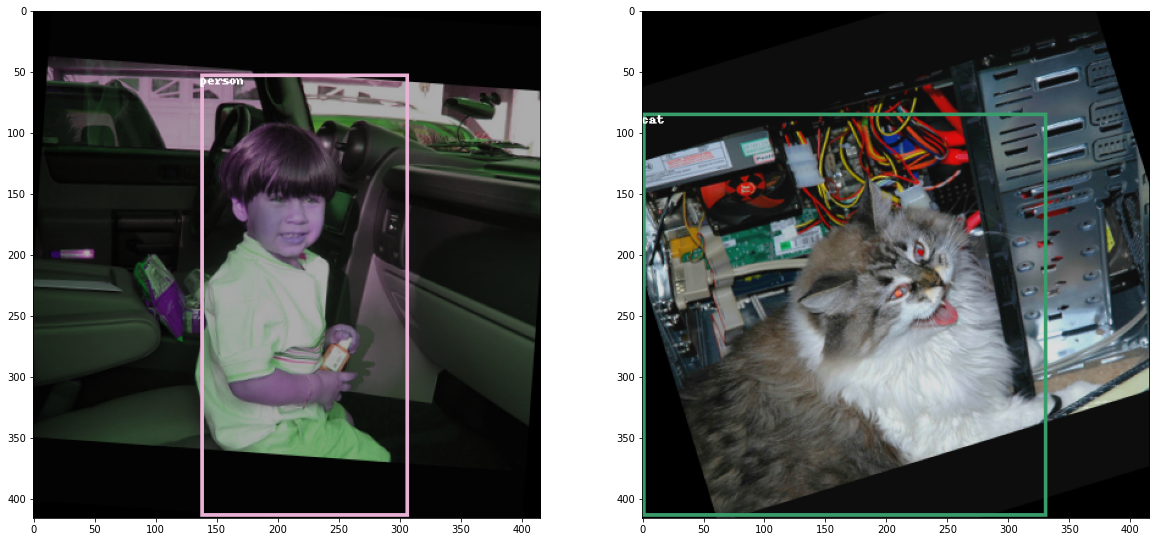

In [136]:
# transforms가 적용된 sample image 확인
np.random.seed(2)

grid_size = 2
rnd_ind = np.random.randint(0, len(train_ds), grid_size)
print('image indices:',rnd_ind)

plt.figure(figsize=(20, 20))
for i, indice in enumerate(rnd_ind):
    img, label, _ = train_ds[indice]
    plt.subplot(1, grid_size, i+1)
    show_img_bbox(img, label)

# 6. DataLoader 생성하기

In [137]:
# collate_fn 를 정의합니다.
# collate_fn은 DataLoader의 인자로 사용되며, batch 단위로 imgs와 targets를 묶습니다.
def collate_fn(batch):
    imgs, targets, paths = list(zip(*batch))
    # 빈 박스 제거하기
    targets = [boxes for boxes in targets if boxes is not None]
    # index 설정하기
    for b_i, boxes in enumerate(targets):
        boxes[:, 0] = b_i
    targets = torch.cat(targets, 0)
    imgs = torch.stack([img for img in imgs])
    return imgs, targets, paths

In [138]:
# make DataLoader
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)

# check train_dl
torch.manual_seed(1)
for imgs_batch, tg_batch, path_batch in train_dl:
    break
print(imgs_batch.shape)
print(tg_batch.shape, tg_batch.dtype)
print(tg_batch)

torch.Size([4, 3, 416, 416])
torch.Size([11, 6]) torch.float32
tensor([[ 0.0000,  0.4680,  0.6207,  0.6040,  0.7533, 19.0000],
        [ 1.0000,  0.8950,  0.6293,  0.1780,  0.4107,  8.0000],
        [ 1.0000,  0.6120,  0.5720,  0.3040,  0.5307, 14.0000],
        [ 1.0000,  0.4620,  0.6067,  0.1760,  0.4507, 14.0000],
        [ 2.0000,  0.6970,  0.6493,  0.2460,  0.6960, 14.0000],
        [ 2.0000,  0.4620,  0.7213,  0.2760,  0.5520, 14.0000],
        [ 2.0000,  0.5370,  0.3613,  0.1100,  0.1840, 14.0000],
        [ 2.0000,  0.4630,  0.3853,  0.0740,  0.1467, 14.0000],
        [ 2.0000,  0.2980,  0.6560,  0.2640,  0.6827, 14.0000],
        [ 2.0000,  0.3920,  0.3880,  0.0800,  0.1520, 14.0000],
        [ 3.0000,  0.4210,  0.5030,  0.8420,  0.9880,  7.0000]])


# 7. YOLOv3 모델 구축하기
- YOLOv3은 FPN을 활용하는 모델입니다. 
- 13x13, 26x26, 52x52 3개의 피쳐맵에서 예측을 수행합니다.

### configuration file 분석하기
- https://github.com/pjreddie/darknet git을 연동 한뒤에, cfg 폴더에 있는 yolov3-voc.cfg 파일을 사용하겠습니다.

In [139]:
!git clone https://github.com/pjreddie/darknet.git

fatal: destination path 'darknet' already exists and is not an empty directory.


In [140]:
# yolov3-voc.cfg 경로를 저장합니다.
path2config = '/darknet/cfg/yolov3-voc.cfg'

In [141]:
# config 파일을 분석하는 함수를 정의합니다.
def parse_model_config(path2file):
    # cfg 파일 열기
    cfg_file = open(path2file, 'r')
    # 문자열 데이터 읽어오기 
    lines = cfg_file.read().split('\n') #['[net]', '# Testing', '# batch=1', '....' ]

    # 데이터 전처리
    # startswith('#'): 문자열이 # 로 시작하는지 여부를 알려줍니다. 
    lines = [x for x in lines if x and not x.startswith('#')] # ['[net]', 'batch=64', '...']
    # 공백 제거
    lines = [x.rstrip().lstrip() for x in lines]

    blocks_list = []
    for line in lines:
        if line.startswith('['): # [net]
            blocks_list.append({}) # {}
            blocks_list[-1]['type'] = line[1:-1].rstrip() # [{'type': 'net'}]
        else:
            key, value = line.split('=') # batch=64 -> batch, 64
            value = value.strip() # 공백 제거
            blocks_list[-1][key.rstrip()] = value.strip() # 'batch':'64'

    return blocks_list

In [142]:
# cfg 파일 분석
blocks_list = parse_model_config(path2config)

### PyTorch 모듈 생성하기
- blocks_list로 PyTorch module list를 생성합니다.

In [143]:
# EmptyLayer를 정의합니다.
# EmptyLayer는 residual unit의 shortcut과 FPN의 lateral connection 용도로 사용합니다.
class EmptyLayer(nn.Module):
    def __init__(self):
        super().__init__()

In [144]:
# YOLOLayer를 정의합니다.
# YOLOLayer는 13x13, 26x26, 52x52 피쳐맵에서 예측을 수행합니다.
class YOLOLayer(nn.Module):
    def __init__(self, anchors, num_classes, img_dim=416):
        super().__init__()
        self.anchors = anchors # three anchor per YOLO layer
        self.num_anchors = len(anchors) # 3
        self.num_classes = num_classes
        self.img_dim = img_dim
        self.grid_size = 0

    def forward(self, x):
        # x: batch_size, channels, H, W
        batch_size = x.size(0)
        grid_size = x.size(2) # S = 13 or 26 or 52
        device = x.device

        prediction = x.view(batch_size, self.num_anchors, self.num_classes + 5, 
                            grid_size, grid_size) # shape = (batch, 3, 25, S, S)

        # (batch, 3, 25, S, S) -> (batch, 3, S, S, 25)
        prediction = prediction.permute(0, 1, 3, 4, 2)
        prediction = prediction.contiguous()

        obj_score = torch.sigmoid(prediction[..., 4]) # 클래스
        pred_cls = torch.sigmoid(prediction[..., 5:]) # 바운딩 박스 좌표

        if grid_size != self.grid_size:
            # grid_size 갱신, cell index 생성, anchor 정규화
            self.compute_grid_offsets(grid_size, cuda=x.is_cuda)

        # bounding box prediction
        pred_boxes = self.transform_outputs(prediction)

        # batch, num_anchor x S x S, 25
        # ex) at 13x13 -> [batch, 507, 25], at 26x26 -> [batch, 2028, 85], at 52x52 -> [batch, 10647, 85]
        # 최종적으로 YOLO는 10647개의 바운딩박스를 예측합니다.
        output = torch.cat((pred_boxes.view(batch_size, -1, 4),
                            obj_score.view(batch_size, -1, 1),
                            pred_cls.view(batch_size, -1, self.num_classes)), -1)
        return output


    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size # ex) 13, 26, 52
        self.stride = self.img_dim / self.grid_size # ex) 32, 16, 8

        # cell index 생성
        # 1, 1, S, 1
        self.grid_x = torch.arange(grid_size, device=device).repeat(1, 1, grid_size, 1).type(torch.float32)
        # 1, 1, 1, S
        self.grid_y = torch.arange(grid_size, device=device).repeat(1, 1, grid_size, 1).transpose(3, 2).type(torch.float32)

        # anchors를 feature map 크기로 정규화, [0~1] 범위
        # ex) (10, 13), (16, 30), (33, 23) / stride
        scaled_anchors = [(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors]
        # tensor로 변환
        self.scaled_anchors = torch.tensor(scaled_anchors, device=device)

        # shape=(3,2) -> (1,1,3,1)
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        # shape=(3,2) -> (1,1,3,1)
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))


    def transform_outputs(self, prediction):
        # pridiction (batch, 3, S, S, 25)
        device = prediction.device
        x = torch.sigmoid(prediction[..., 0]) # sigmoid(box x), 예측값을 sigmoid로 감싸서 [0~1] 범위
        y = torch.sigmoid(prediction[..., 1]) # sigmoid(box y), 예측값을 sigmoid로 감싸서 [0~1] 범위
        w = prediction[..., 2] # 예측한 바운딩 박스 너비
        h = prediction[..., 3] # 예측한 바운딩 박스 높이

        pred_boxes = torch.zeros_like(prediction[..., :4]).to(device)
        pred_boxes[..., 0] = x.data + self.grid_x # sigmoid(box x) + cell x 좌표
        pred_boxes[..., 1] = y.data + self.grid_y # sigmoid(box y) + cell y 좌표
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h

        return pred_boxes * self.stride    


In [145]:
# layer를 생성하는 함수를 정의합니다.
def create_layers(blocks_list):
    hyperparams = blocks_list[0]
    channels_list = [int(hyperparams['channels'])]
    module_list = nn.ModuleList()

    for layer_ind, layer_dict in enumerate(blocks_list[1:]):
        modules = nn.Sequential()

        if layer_dict['type'] == 'convolutional':
            filters = int(layer_dict['filters'])
            kernel_size = int(layer_dict['size'])
            pad = (kernel_size - 1) // 2
            bn = layer_dict.get('batch_normalize', 0)

            conv2d = nn.Conv2d(in_channels=channels_list[-1], out_channels=filters, kernel_size=kernel_size,
                               stride=int(layer_dict['stride']), padding=pad, bias=not bn)
            modules.add_module('conv_{0}'.format(layer_ind), conv2d)

            if bn:
                bn_layer = nn.BatchNorm2d(filters, momentum=0.9, eps=1e-5)
                modules.add_module('batch_norm_{0}'.format(layer_ind), bn_layer)
            
            if layer_dict['activation'] == 'leaky':
                activn = nn.LeakyReLU(0.1)
                modules.add_module('leky_{0}'.format(layer_ind), activn)

        elif layer_dict["type"] == "upsample":
            stride = int(layer_dict["stride"])
            upsample = nn.Upsample(scale_factor = stride)
            modules.add_module("upsample_{}".format(layer_ind), upsample) 

        elif layer_dict["type"] == "shortcut":
            backwards=int(layer_dict["from"])
            filters = channels_list[1:][backwards]
            modules.add_module("shortcut_{}".format(layer_ind), EmptyLayer())
            
        elif layer_dict["type"] == "route":
            layers = [int(x) for x in layer_dict["layers"].split(",")]
            filters = sum([channels_list[1:][l] for l in layers])
            modules.add_module("route_{}".format(layer_ind), EmptyLayer())

        elif layer_dict["type"] == "yolo":
            anchors = [int(a) for a in layer_dict["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]

            # ex) at 13x13, 'mask': '6,7,8'
            # mask는 anchors index를 의미합니다.
            # yolo layer당 3개의 anchors를 할당 합니다.
            # mask는 yolo layer feature map size에 알맞는 anchors를 설정합니다.
            mask = [int(m) for m in layer_dict["mask"].split(",")]
            
            anchors = [anchors[i] for i in mask] # 3 anchors
            
            num_classes = int(layer_dict["classes"]) # 20
            img_size = int(hyperparams["height"]) # 416 
            
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module("yolo_{}".format(layer_ind), yolo_layer)
            
        module_list.append(modules)       
        channels_list.append(filters)

    return hyperparams, module_list        

In [146]:
# check 'create_layers' function
hy_pa, m_l = create_layers(blocks_list)
print(hy_pa)
print(m_l)

{'type': 'net', 'batch': '1', 'subdivisions': '1', 'width': '416', 'height': '416', 'channels': '3', 'momentum': '0.9', 'decay': '0.0005', 'angle': '0', 'saturation': '1.5', 'exposure': '1.5', 'hue': '.1', 'learning_rate': '0.001', 'burn_in': '1000', 'max_batches': '50200', 'policy': 'steps', 'steps': '40000,45000', 'scales': '.1,.1'}
ModuleList(
  (0): Sequential(
    (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leky_0): LeakyReLU(negative_slope=0.1)
  )
  (1): Sequential(
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (leky_1): LeakyReLU(negative_slope=0.1)
  )
  (2): Sequential(
    (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (batch_norm_2): BatchNorm2d(32, eps

### 생성한 module list로 DarkNet을 구축합니다.

In [147]:
class Darknet(nn.Module):
    def __init__(self, config_path, img_size=416):
        super(Darknet, self).__init__()
        self.blocks_list = parse_model_config(config_path)
        self.hyperparams, self.module_list = create_layers(self.blocks_list)
        self.img_size = img_size
        
    def forward(self, x):
        img_dim = x.shape[2]
        layer_outputs, yolo_outputs = [], []
        
        # blocks_list: config 파일 분석한 결과
        # module_list: blocks_list로 생성한 module
        for block, module in zip(self.blocks_list[1:], self.module_list):
            if block["type"] in ["convolutional", "upsample", "maxpool"]:
                x = module(x)        
                
                
            elif block["type"] == "shortcut":
                layer_ind = int(block["from"]) # -3
                x = layer_outputs[-1] + layer_outputs[layer_ind] # shortcut connection

            #  {'type': 'yolo', 'mask': '3,4,5', 'anchors': '10,13, ...}
            elif block["type"] == "yolo":
                x= module[0](x) # get yolo layer output
                yolo_outputs.append(x)
            elif block["type"] == "route": #  {'type': 'route', 'layers': '-1, 61'}
                x = torch.cat([layer_outputs[int(l_i)] 
                               for l_i in block["layers"].split(",")], 1)
            layer_outputs.append(x)
        yolo_out_cat = torch.cat(yolo_outputs, 1) # 3개의 output을 하나로 연결
        return yolo_out_cat, yolo_outputs

In [148]:
# check model
model = Darknet(path2config).to(device)
x=torch.rand(1,3,416,416).to(device)
with torch.no_grad():
    yolo_out_cat, yolo_outputs=model.forward(x)
    print(yolo_out_cat.shape)
    print(yolo_outputs[0].shape,yolo_outputs[1].shape,yolo_outputs[2].shape)

torch.Size([1, 10647, 25])
torch.Size([1, 507, 25]) torch.Size([1, 2028, 25]) torch.Size([1, 8112, 25])


In [149]:
summary(model, (3, 416, 416))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 416, 416]             864
       BatchNorm2d-2         [-1, 32, 416, 416]              64
         LeakyReLU-3         [-1, 32, 416, 416]               0
            Conv2d-4         [-1, 64, 208, 208]          18,432
       BatchNorm2d-5         [-1, 64, 208, 208]             128
         LeakyReLU-6         [-1, 64, 208, 208]               0
            Conv2d-7         [-1, 32, 208, 208]           2,048
       BatchNorm2d-8         [-1, 32, 208, 208]              64
         LeakyReLU-9         [-1, 32, 208, 208]               0
           Conv2d-10         [-1, 64, 208, 208]          18,432
      BatchNorm2d-11         [-1, 64, 208, 208]             128
        LeakyReLU-12         [-1, 64, 208, 208]               0
           Conv2d-13        [-1, 128, 104, 104]          73,728
      BatchNorm2d-14        [-1, 128, 1

# 8. 손실 함수 정의하기
- YOLOv3의 loss function은 4개의 term으로 이루어져 있습니다.
- https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter05/Chapter%205.ipynb 에 잘 구현되어 있어서 갖고 왔습니다.

In [150]:
def get_loss_batch(output,targets, params_loss, opt=None):
    ignore_thres=params_loss["ignore_thres"]
    scaled_anchors= params_loss["scaled_anchors"] # 정규화된 anchor   
    mse_loss= params_loss["mse_loss"] # nn.MSELoss
    bce_loss= params_loss["bce_loss"] # nn.BCELoss, 이진 분류에서 사용
    
    num_yolos=params_loss["num_yolos"] # 3
    num_anchors= params_loss["num_anchors"] # 3
    obj_scale= params_loss["obj_scale"] # 1
    noobj_scale= params_loss["noobj_scale"] # 100

    loss = 0.0

    for yolo_ind in range(num_yolos):
        yolo_out = output[yolo_ind] # yolo_out: batch, num_boxes, class+coordinates
        batch_size, num_bbxs, _ = yolo_out.shape

        # get grid size
        gz_2 = num_bbxs/num_anchors # ex) at 13x13, 507 / 3
        grid_size=int(np.sqrt(gz_2))

        # (batch, num_boxes, class+coordinates) -> (batch, num_anchors, S, S, class+coordinates)
        yolo_out = yolo_out.view(batch_size, num_anchors, grid_size, grid_size, -1)

        pred_boxes = yolo_out[:,:,:,:,:4] # get box coordinates
        x,y,w,h = transform_bbox(pred_boxes, scaled_anchors[yolo_ind]) # cell 내에서 x,y 좌표와  
        pred_conf = yolo_out[:,:,:,:,4] # get confidence
        pred_cls_prob = yolo_out[:,:,:,:,5:]

        yolo_targets = get_yolo_targets({
            'pred_cls_prob':pred_cls_prob,
            'pred_boxes':pred_boxes,
            'targets':targets,
            'anchors':scaled_anchors[yolo_ind],
            'ignore_thres':ignore_thres,
        })

        obj_mask=yolo_targets["obj_mask"]        
        noobj_mask=yolo_targets["noobj_mask"]            
        tx=yolo_targets["tx"]                
        ty=yolo_targets["ty"]                    
        tw=yolo_targets["tw"]                        
        th=yolo_targets["th"]                            
        tcls=yolo_targets["tcls"]                                
        t_conf=yolo_targets["t_conf"]

        loss_x = mse_loss(x[obj_mask], tx[obj_mask])
        loss_y = mse_loss(y[obj_mask], ty[obj_mask])
        loss_w = mse_loss(w[obj_mask], tw[obj_mask])
        loss_h = mse_loss(h[obj_mask], th[obj_mask])
        
        loss_conf_obj = bce_loss(pred_conf[obj_mask], t_conf[obj_mask])
        loss_conf_noobj = bce_loss(pred_conf[noobj_mask], t_conf[noobj_mask])
        loss_conf = obj_scale * loss_conf_obj + noobj_scale * loss_conf_noobj
        loss_cls = bce_loss(pred_cls_prob[obj_mask], tcls[obj_mask])
        loss += loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls
        
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss.item()

In [151]:
def transform_bbox(bbox, anchors):
    # bbox: predicted bbox coordinates
    # anchors: scaled anchors

    x = bbox[:,:,:,:,0]
    y = bbox[:,:,:,:,1]
    w = bbox[:,:,:,:,2]
    h = bbox[:,:,:,:,3]
    anchor_w = anchors[:,0].view((1,3,1,1))
    anchor_h = anchors[:,1].view((1,3,1,1))

    x=x-x.floor() # 전체 이미지의 x 좌표에서 셀 내의 x좌표로 변경
    y=y-y.floor() # 전체 이미지의 y 좌표에서 셀 내의 y좌표로 변경
    w=torch.log(w / anchor_w + 1e-16)
    h=torch.log(h / anchor_h + 1e-16)
    return x, y, w, h

In [152]:
def get_yolo_targets(params):
    pred_boxes = params['pred_boxes']
    pred_cls_prob = params['pred_cls_prob']
    target = params['targets'] # batchsize, cls, cx, cy, w, h
    anchors = params['anchors']
    ignore_thres = params['ignore_thres']

    batch_size = pred_boxes.size(0)
    num_anchors = pred_boxes.size(1)
    grid_size = pred_boxes.size(2)
    num_cls = pred_cls_prob.size(-1)


    sizeT = batch_size, num_anchors, grid_size, grid_size
    obj_mask = torch.zeros(sizeT, device=device, dtype=torch.uint8)
    noobj_mask = torch.ones(sizeT, device=device, dtype=torch.uint8)
    tx = torch.zeros(sizeT, device=device, dtype=torch.float32)
    ty = torch.zeros(sizeT, device=device, dtype=torch.float32)
    tw = torch.zeros(sizeT, device=device, dtype=torch.float32)
    th = torch.zeros(sizeT, device=device, dtype=torch.float32)

    sizeT = batch_size, num_anchors, grid_size, grid_size, num_cls
    tcls = torch.zeros(sizeT, device=device, dtype=torch.float32)

    # target = batch, cx, cy, w, h, class
    target_bboxes = target[:, 1:5] * grid_size
    t_xy = target_bboxes[:, :2]
    t_wh = target_bboxes[:, 2:]
    t_x, t_y = t_xy.t() # .t(): 전치
    t_w, t_h = t_wh.t() # .t(): 전치

    grid_i, grid_j = t_xy.long().t() # .long(): int로 변환

    # anchor와 target의 iou 계산
    iou_with_anchors = [get_iou_WH(anchor, t_wh) for anchor in anchors]
    iou_with_anchors = torch.stack(iou_with_anchors)
    best_iou_wa, best_anchor_ind = iou_with_anchors.max(0) # iou가 가장 높은 anchor 추출

    batch_inds, target_labels = target[:, 0].long(), target[:, 5].long()
    obj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 1 # iou가 가장 높은 anchor 할당
    noobj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 0

    # threshold 보다 높은 iou를 지닌 anchor
    # iou가 가장 높은 anchor만 할당하면 되기 때문입니다.
    for ind, iou_wa in enumerate(iou_with_anchors.t()):
        noobj_mask[batch_inds[ind], iou_wa > ignore_thres, grid_j[ind], grid_i[ind]] = 0

    # cell 내에서 x,y로 변환
    tx[batch_inds, best_anchor_ind, grid_j, grid_i] = t_x - t_x.float()
    ty[batch_inds, best_anchor_ind, grid_j, grid_i] = t_y - t_y.float()

    anchor_w = anchors[best_anchor_ind][:, 0]
    tw[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_w / anchor_w + 1e-16)

    anchor_h = anchors[best_anchor_ind][:, 1]
    th[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_h / anchor_h + 1e-16)

    tcls[batch_inds, best_anchor_ind, grid_j, grid_i, target_labels] = 1

    output = {
        'obj_mask': obj_mask,
        'noobj_mask': noobj_mask,
        'tx': tx,
        'ty': ty,
        'tw': tw,
        'th': th,
        'tcls': tcls,
        't_conf': obj_mask.float(),
    }
    return output

In [153]:
# anchor와 target box의 iou 계산하는 함수입니다.
def get_iou_WH(wh1, wh2):
    wh2 = wh2.t()
    w1, h1 = wh1[0], wh1[1]
    w2, h2 = wh2[0], wh2[1]
    inter_area = torch.min(w1, w2) * torch.min(h1, h2)
    union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
    return inter_area / union_area

# 9. 모델 학습하기
- 학습에 필요한 함수를 정의하고, 학습을 진행합니다.

In [154]:
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [155]:
# 현재 lr 계산하는 함수
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [156]:
# epoch당 loss 계산하는 함수
def loss_epoch(model,params_loss,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    len_data=len(dataset_dl.dataset)
    running_metrics= {}
    
    for xb, yb,_ in dataset_dl:
        yb=yb.to(device)
        _,output=model(xb.to(device))
        loss_b=get_loss_batch(output,yb, params_loss,opt)
        running_loss+=loss_b
        if sanity_check is True:
            break 
    loss=running_loss/float(len_data)
    return loss

In [161]:
import time
def train_val(model, params):
    num_epochs=params["num_epochs"]
    params_loss=params["params_loss"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    
    loss_history={
        "train": [],
        "val": [],
    }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf') 
    
    start_time = time.time()
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr)) 
        model.train()
        train_loss=loss_epoch(model,params_loss,train_dl,sanity_check,opt)
        loss_history["train"].append(train_loss)  
        
        model.eval()
        with torch.no_grad():
            val_loss=loss_epoch(model,params_loss,val_dl,sanity_check)
        loss_history["val"].append(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            print('Get best val loss')
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
        print("train loss: %.6f, val loss: %.6f, time: %.4f min" %(train_loss, val_loss, (time.time()-start_time)/60))
        print("-"*10) 
    model.load_state_dict(best_model_wts)
    return model, loss_history

In [162]:
path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)
        
scaled_anchors=[model.module_list[82][0].scaled_anchors,
                model.module_list[94][0].scaled_anchors,
                model.module_list[106][0].scaled_anchors]

In [159]:
mse_loss = nn.MSELoss(reduction="sum")
bce_loss = nn.BCELoss(reduction="sum")
params_loss={
    "scaled_anchors" : scaled_anchors,
    "ignore_thres": 0.5,
    "mse_loss": mse_loss,
    "bce_loss": bce_loss,
    "num_yolos": 3,
    "num_anchors": 3,
    "obj_scale": 1,
    "noobj_scale": 100,
}

In [163]:
params_train={
    "num_epochs": 3,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}
model,loss_hist=train_val(model,params_train)

Epoch 0/2, current lr=0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/pytho

Copied best model weights!
Get best val loss
train loss: 208.580587, val loss: 206.690529, time: 25.8085 min
----------
Epoch 1/2, current lr=0.001
Copied best model weights!
Get best val loss
train loss: 207.872358, val loss: 205.813346, time: 51.4753 min
----------
Epoch 2/2, current lr=0.001
train loss: 206.986991, val loss: 206.911006, time: 77.1200 min
----------


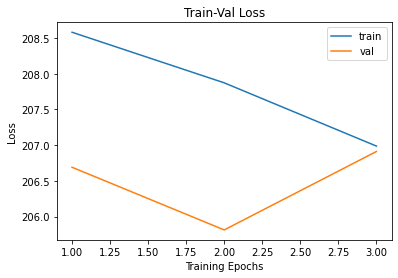

In [168]:
num_epochs = params_train['num_epochs']

# Plot train-val loss
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()